In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer
from IPython.display import display, HTML
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from utils import *
from npeet import entropy_estimators as ee #

In [2]:
# Automatically choose (prefer NVIDIA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify model name
model_name = "facebook/bart-base"
tokenizer_bart = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Specify model name
summarizer_name = "Falconsai/text_summarization"
tokenizer_sum = T5Tokenizer.from_pretrained(summarizer_name)
summarizer = T5ForConditionalGeneration.from_pretrained(summarizer_name).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
original_text = """
Beginners BBQ Class Taking Place in Missoula! 
Do you want to get better at making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The cost to be in the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
""".replace("\n", "")

# original_text = """
# Sport is an important part of Australian culture because the climate is good for outdoor 
# activities. 23.5% Australians over the age of 15 regularly take part in organised sporting activities. 
# In international sports, Australia has very strong teams in cricket, hockey, netball, rugby league and 
# rugby union, and performs well in cycling, rowing and swimming. Local popular sports include 
# Australian Rules Football, horse racing, soccer and motor racing. Australia has participated 
# in every summer Olympic Games since 1896, and every Commonwealth Games. Australia has hosted 
# the 1956 and 2000 Summer Olympics, and has ranked in the top five medal-winners since 2000. A
# ustralia has also hosted the 1938, 1962, 1982 and 2006 Commonwealth Games and are to host the 
# 2018 Commonwealth Games. Other major international events held regularly in Australia include 
# the Australian Open, one of the four Grand Slam tennis tournaments, annual international cricket 
# matches and the Formula One Australian Grand Prix. Corporate and government sponsorship of many 
# sports and elite athletes is common in Australia. Televised sport is popular; some of the 
# highest-rated television programs include the Summer Olympic Games and the grand finals of 
# local and international football competitions.
# """.replace("\n", "")

In [4]:
input_text_ls = []
nr_rounds = 10

for _ in range(nr_rounds):
    input_text_ls.append(masking(original_text, 4/130))

original_ids = tokenizer_sum('Summarize: ' + original_text, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    original_encoder_outputs = summarizer.encoder(input_ids=original_ids)
    
original_sum_output = summarizer.generate(input_ids=None, encoder_outputs=original_encoder_outputs, max_length=70, output_hidden_states=True,
                                        return_dict_in_generate=True, do_sample=True, num_beams=10, temperature=0.1)
original_summary = tokenizer_sum.decode(original_sum_output.sequences[0], skip_special_tokens=True)
print(original_summary)
em_original_summary = extract_hidden_states(original_sum_output.decoder_hidden_states)

em_baseline_summary = []

for i in tqdm(range(nr_rounds)):
    input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        encoder_outputs = model.model.encoder(input_ids=input_ids)
        
    # first LLM
    baseline_outputs = model.generate(input_ids=None, encoder_outputs=encoder_outputs, max_length=300, min_length=100, 
                                    num_beams=15, do_sample=True, temperature=0.15, early_stopping=True)
    baseline_text = tokenizer_bart.decode(baseline_outputs[0], skip_special_tokens=True)
    # print(baseline_text)

    
    baseline_ids = tokenizer_sum('Summarize: ' + baseline_text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        baseline_encoder_outputs = summarizer.encoder(input_ids=baseline_ids)
        
    baseline_sum_output = summarizer.generate(input_ids=None, encoder_outputs=baseline_encoder_outputs, max_length=70, output_hidden_states=True,
                                            return_dict_in_generate=True, do_sample=True, num_beams=10, temperature=0.1)
    baseline_summary = tokenizer_sum.decode(baseline_sum_output.sequences[0], skip_special_tokens=True)
    # print(baseline_summary)
    em_baseline_summary.append(extract_hidden_states(baseline_sum_output.decoder_hidden_states))

KCBS BBQ Class Taking Place in Missoula! The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# Define SNR range
# snr_range = list(range(-20, 21, 6)) + list(range(22, 55, 5)) + list(range(64, 101, 6)) 
# snr_range = list(range(-3, 20, 4)) 
snr_range = list(range(-10, 41))
# snr_range = torch.linspace(0.8, 0, 20)
cs_list_mean = []
cs_list_lower = []
cs_list_upper = []
mi_list_mean = []
mi_list_lower = []
mi_list_upper = []


for target_snr in tqdm(snr_range):
    cs_list_texts = []
    mi_list_texts = []
    for i in tqdm(range(nr_rounds)):
        input_ids = tokenizer_bart(input_text_ls[i], return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_ids=input_ids)
        
        # add noise
        noisy_encoder_output = add_noise_with_snr(
            encoder_output = encoder_outputs.last_hidden_state,
            noise_type = "gaussian",
            target_snr_db = target_snr,
            dropout_rate = 0,
            sp_thresh = 0
        )
        modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)
        
        # first LLM
        noisy_outputs = model.generate(input_ids=None, encoder_outputs=modified_encoder_outputs, max_length=300, min_length=100, 
                                    num_beams=15, do_sample=True, temperature=0.15, early_stopping=True)
        noisy_text = tokenizer_bart.decode(noisy_outputs[0], skip_special_tokens=True)
        #print(noisy_text)
    
        # second LLM
        noisy_ids = tokenizer_sum('Summarize: ' + noisy_text, return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            noisy_encoder_outputs = summarizer.encoder(input_ids=noisy_ids)
        noisy_sum_output = summarizer.generate(input_ids=None, encoder_outputs=noisy_encoder_outputs, max_length=70, output_hidden_states=True,
                                            return_dict_in_generate=True, do_sample=True, num_beams=10, temperature=0.1)
        noisy_summary = tokenizer_sum.decode(noisy_sum_output.sequences[0], skip_special_tokens=True)
        #print(noisy_summary)
        
        
        # get embeddings
        em_noisy_summary = extract_hidden_states(noisy_sum_output.decoder_hidden_states)
        
        # pad each embedding with embedding of baseline
        pad_em_baseline_summary, pad_em_noisy_summary = align_tensors(em_baseline_summary[i], em_noisy_summary)
        
        # calculate cs
        cs_list_texts.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=1).mean().item())
    
        # calculate mi
        em_noisy_summary_np = em_noisy_summary.cpu().numpy()
        em_baseline_summary_np = em_baseline_summary[i].cpu().numpy()
        mi_list_texts.append(ksg(em_baseline_summary_np, em_noisy_summary_np))
    
    # for each snr calculate mean cs and mi
    cs_list_mean.append(np.mean(cs_list_texts))
    mi_list_mean.append(np.mean(mi_list_texts))
    

    z = 1.96  # For 95% confidence level
    cs_list_std = np.std(cs_list_texts, axis=0)
    margin_of_error = z * (cs_list_std / np.sqrt(nr_rounds))
    cs_list_lower.append(cs_list_mean[-1] - margin_of_error)
    cs_list_upper.append(cs_list_mean[-1] + margin_of_error)
    # print(cs_list_lower)

    mi_list_std = np.std(mi_list_texts, axis=0)
    margin_of_error = z * (mi_list_std / np.sqrt(nr_rounds))
    mi_list_lower.append(mi_list_mean[-1] - margin_of_error)
    mi_list_upper.append(mi_list_mean[-1] + margin_of_error)
    
cs_base_orig_ls = []
mi_base_orig_ls = []
for i in range(nr_rounds):
    pad_em_baseline_summary, pad_em_original_summary = align_tensors(em_baseline_summary[i], em_original_summary)
    cs_base_orig_ls.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_original_summary, dim=1).mean().item())

    em_original_summary_np = em_original_summary.cpu().numpy()
    em_baseline_summary_np = em_baseline_summary[i].cpu().numpy()

    mi_base_orig_ls.append(ksg(em_baseline_summary_np, em_original_summary_np))
    
cs_base_orig_mean = np.mean(cs_base_orig_ls)
mi_base_orig_mean = np.mean(mi_base_orig_ls)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

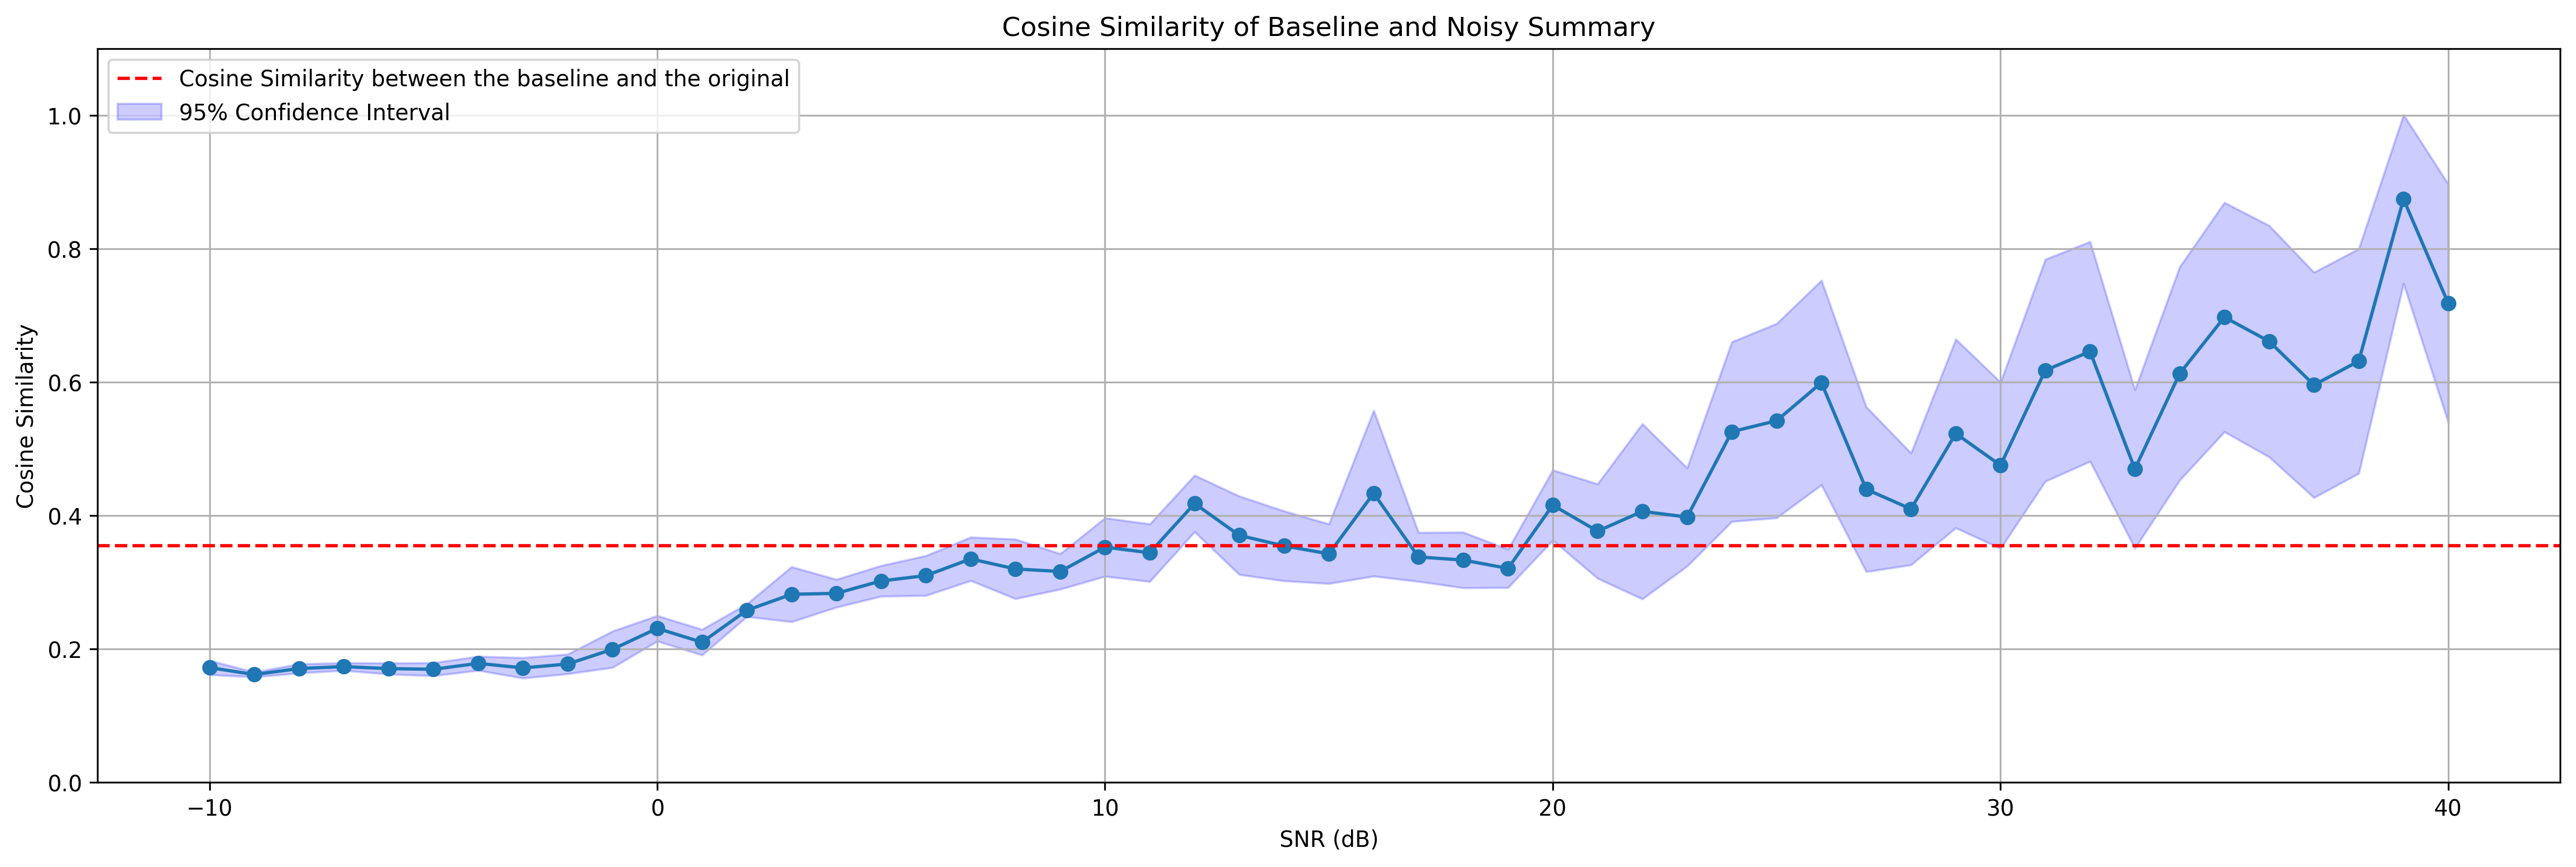

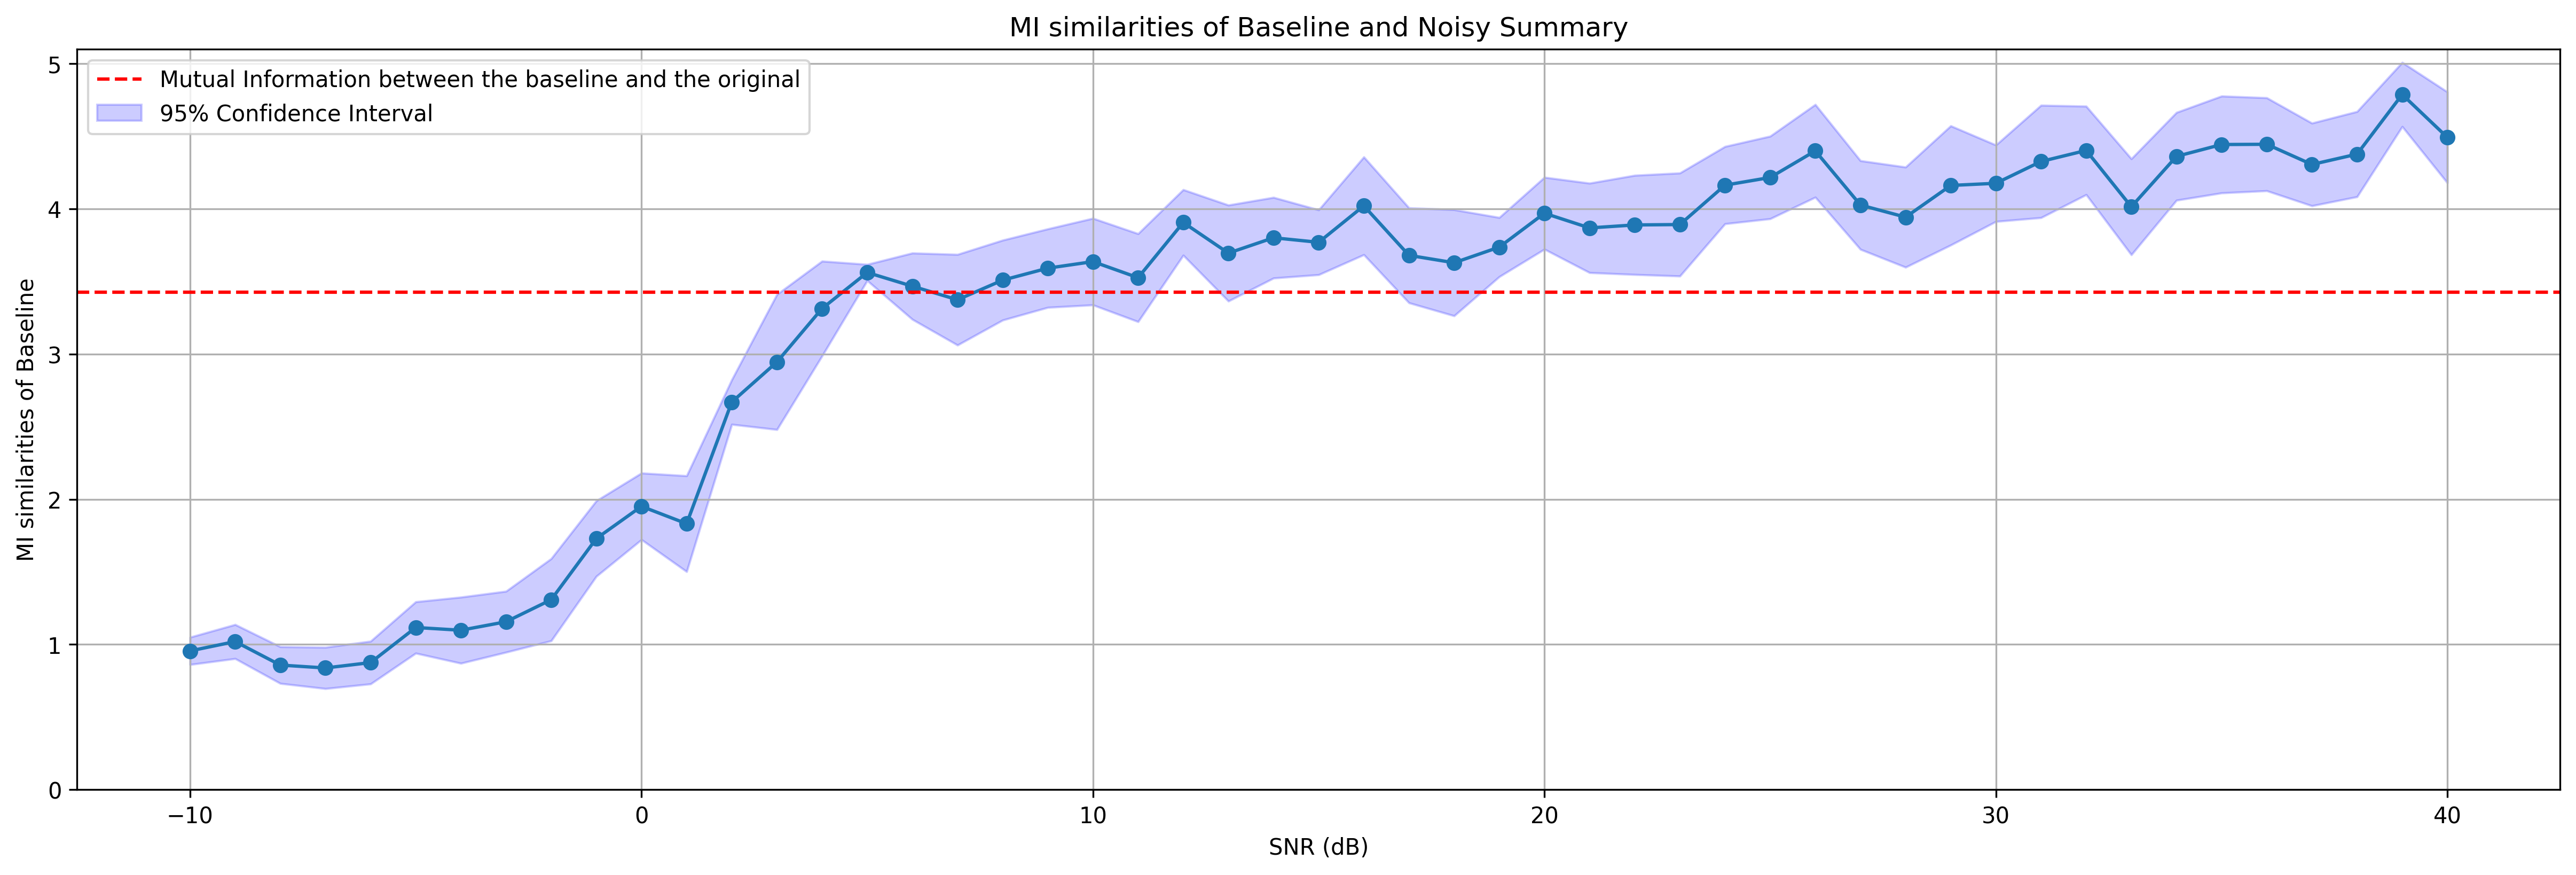

In [6]:
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, cs_list_mean, marker='o')
plt.axhline(y=cs_base_orig_mean, color='r', linestyle='--', label='Cosine Similarity between the baseline and the original')
plt.fill_between(snr_range, cs_list_lower, cs_list_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.ylim([0.0,1.1])
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Baseline and Noisy Summary")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, mi_list_mean, marker='o')
plt.axhline(y=mi_base_orig_mean, color='r', linestyle='--', label='Mutual Information between the baseline and the original')
plt.fill_between(snr_range, mi_list_lower, mi_list_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.ylim([0.0,5.1])
plt.xlabel("SNR (dB)")
plt.ylabel("MI similarities of Baseline")
plt.title("MI similarities of Baseline and Noisy Summary")
plt.grid()
plt.legend()
plt.show()